**1. Setup and Data Loading**

In [ ]:
# ===============================
# 1. Setup and Data Loading
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.decomposition import PCA

# Project paths
BASE_DIR = "Anomaly_Detection_Pipeline"
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")
PUBLIC_BENIGN_FILE = os.path.join(DATA_DIR, "public_benign_set.csv")
PRIVATE_BENIGN_FILE = os.path.join(DATA_DIR, "private_benign_set.csv")
# Load processed datasets
public_df = pd.read_csv(PUBLIC_BENIGN_FILE)
private_df = pd.read_csv(PRIVATE_BENIGN_FILE)

print(f"Public benign set: {public_df.shape}")
print(f"Private benign set: {private_df.shape}")


Public benign set: (2095022, 77)
Private benign set: (15842, 69)


**2. Log Transformation for Scale Alignment**

In [ ]:
# ===============================
# 2. Log Transformation for Scale Alignment
# ===============================

def safe_log_transform(df):
    """
    Apply a safe log transform to numeric columns.
    Shift ensures all values are positive before applying log1p.
    """
    df_num = df.select_dtypes(include=[np.number])
    df_logged = np.log1p(df_num - df_num.min() + 1e-9)
    return df_logged

benign_public_log = safe_log_transform(public_df)
benign_private_log = safe_log_transform(private_df)

print("Applied safe log-transform to both datasets.")


Applied safe log-transform to both datasets.


**3. Distributional Drift Metrics (KS, Wasserstein, Mean/Std)**

In [ ]:
# ===============================
# 3. Drift Metrics: KS, Wasserstein, Mean and Std
# ===============================

def compute_drift_metrics(df1, df2):
    drift_data = []
    for col in df1.columns:
        if col not in df2.columns or not np.issubdtype(df1[col].dtype, np.number):
            continue
        x1, x2 = df1[col].dropna(), df2[col].dropna()
        if len(np.unique(x1)) < 2 or len(np.unique(x2)) < 2:
            continue
        ks_stat, _ = ks_2samp(x1, x2)
        emd = wasserstein_distance(x1, x2)
        drift_data.append({
            "Feature": col,
            "KS_Statistic": ks_stat,
            "Earth_Mover_Distance": emd,
            "Mean_Public": x1.mean(),
            "Mean_Private": x2.mean(),
            "Mean_Diff": x2.mean() - x1.mean(),
            "Std_Public": x1.std(),
            "Std_Private": x2.std(),
            "Std_Ratio": x2.std() / (x1.std() + 1e-9)
        })
    return pd.DataFrame(drift_data)

drift_df = compute_drift_metrics(benign_public_log, benign_private_log)
drift_df.sort_values("KS_Statistic", ascending=False, inplace=True)

print("Top 10 features with highest distribution shift:")
display(drift_df.head(10))


Top 10 features with highest distribution shift:


,Feature,KS_Statistic,Earth_Mover_Distance,Mean_Public,Mean_Private,Mean_Diff,Std_Public,Std_Private,Std_Ratio
16,Flow IAT Mean,0.922527,8.551004,8.879906,0.328902,-8.551004,4.280425,0.650301,0.151924
18,Flow IAT Max,0.882219,8.897670,9.810827,0.913157,-8.897670,4.803231,1.294380,0.269481
1,Flow Duration,0.820958,9.019826,10.128832,1.109006,-9.019826,5.063051,1.500151,0.296294
23,Fwd IAT Min,0.741181,2.871667,2.871670,0.000003,-2.871667,3.791480,0.000426,0.000112
54,act_data_pkt_fwd,0.676674,0.828048,0.836448,1.664477,0.828029,0.875187,1.071405,1.224202
53,Init_Win_bytes_backward,0.653904,4.327799,5.584316,2.940637,-2.643680,1.928712,4.652705,2.412338
17,Flow IAT Std,0.644300,6.454816,6.937372,0.501807,-6.435566,6.031081,0.853545,0.141524
52,Init_Win_bytes_forward,0.633994,5.378607,8.270323,3.372869,-4.897454,1.971582,4.726257,2.397190
20,Fwd IAT Mean,0.609329,5.371024,5.710372,0.339348,-5.371024,6.023602,0.766564,0.127260
28,Bwd IAT Min,0.571522,2.007674,2.054371,0.046696,-2.007674,3.363728,0.400314,0.119009


**4. Visualizing Drift Intensity**

/tmp/ipython-input-1853222720.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


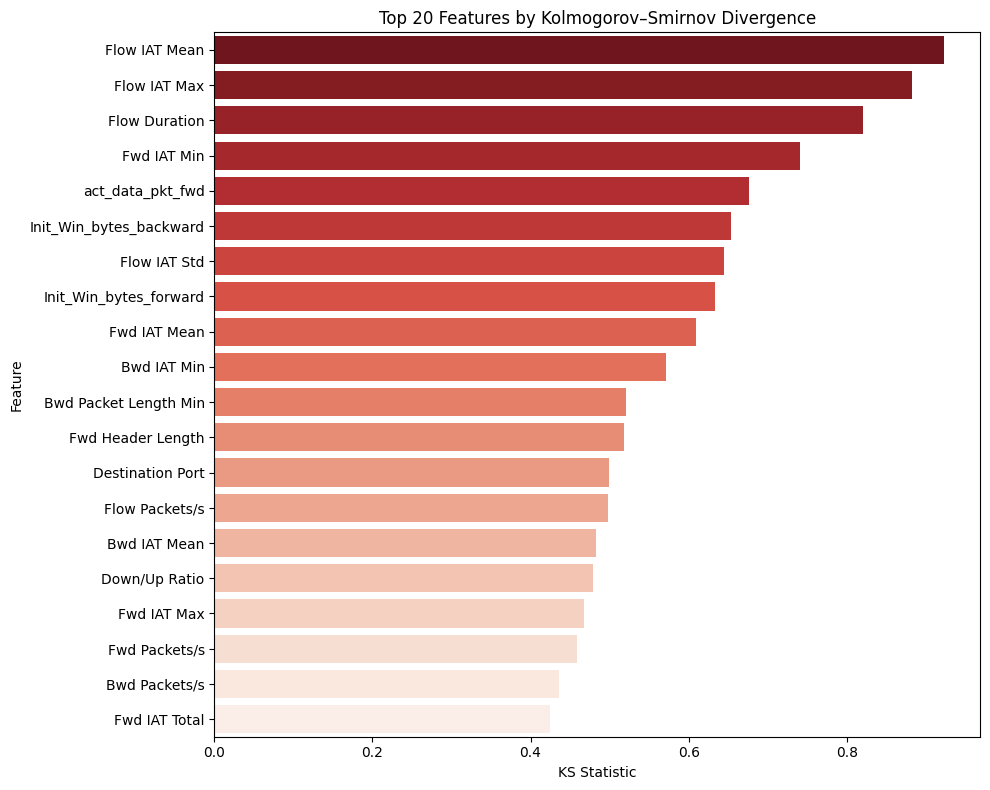

In [ ]:
# ===============================
# 4. Drift Intensity Visualization
# ===============================

plt.figure(figsize=(10, 8))
sns.barplot(
    data=drift_df.head(20),
    y="Feature",
    x="KS_Statistic",
    palette="Reds_r"
)
plt.title("Top 20 Features by Kolmogorov–Smirnov Divergence")
plt.xlabel("KS Statistic")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**5. Segmented Divergence Analysis (Core/Mid/High/Extreme)**

In [ ]:
# ===============================
# 5. Segmented Divergence Analysis
# ===============================

def segmented_divergence_analysis(df_public, df_private, step=0.001):
    numeric_cols = df_public.select_dtypes(include=[np.number]).columns
    percentiles = np.arange(0.001, 0.999, step)

    records = []
    for col in numeric_cols:
        q_pub = df_public[col].quantile(percentiles)
        q_sml = df_private[col].quantile(percentiles)
        ratio = q_sml / q_pub.replace(0, np.nan)

        core_mean = np.nanmean(ratio[percentiles < 0.5])
        mid_mean = np.nanmean(ratio[(percentiles >= 0.5) & (percentiles < 0.9)])
        high_mean = np.nanmean(ratio[(percentiles >= 0.9) & (percentiles < 0.99)])
        extreme_mean = np.nanmean(ratio[percentiles >= 0.99])

        ks_stat, ks_p = ks_2samp(df_public[col].dropna(), df_private[col].dropna())

        records.append({
            "Feature": col,
            "Core": core_mean,
            "Mid": mid_mean,
            "High": high_mean,
            "Extreme": extreme_mean,
            "KS_Stat": ks_stat,
            "p_value": ks_p
        })

    df_seg = pd.DataFrame(records).sort_values("KS_Stat", ascending=False)
    return df_seg

df_seg = segmented_divergence_analysis(benign_public_log, benign_private_log)

print("Top 10 features with segment-level divergence:")
display(df_seg.head(10))


Top 10 features with segment-level divergence:


,Feature,Core,Mid,High,Extreme,KS_Stat,p_value
60,min_seg_size_forward,3.284587e-10,2.889691e-10,2.828420e-10,2.678191e-10,0.999192,0.0
19,Flow IAT Min,4.609219e-02,2.622045e-10,8.882549e-11,6.958001e-11,0.976175,0.0
16,Flow IAT Mean,6.151994e-03,2.077381e-02,1.217055e-01,2.021661e-01,0.922527,0.0
18,Flow IAT Max,2.895967e-02,8.156731e-02,2.287430e-01,2.580798e-01,0.882219,0.0
1,Flow Duration,2.993711e-02,1.030974e-01,2.440872e-01,2.618531e-01,0.820958,0.0
24,Fwd IAT Min,5.170341e-01,3.986544e-10,8.889139e-11,5.511738e-11,0.741181,0.0
59,act_data_pkt_fwd,6.740386e+08,1.816269e+00,1.298885e+00,1.961511e+00,0.676674,0.0
58,Init_Win_bytes_backward,1.022044e-01,7.718691e-01,1.191823e+00,1.000684e+00,0.653904,0.0
17,Flow IAT Std,1.927507e+07,3.871955e-02,1.667389e-01,2.012706e-01,0.644300,0.0
57,Init_Win_bytes_forward,2.004008e-02,6.063140e-01,1.047942e+00,1.000000e+00,0.633994,0.0


**6. Heatmap of Segment Ratios**

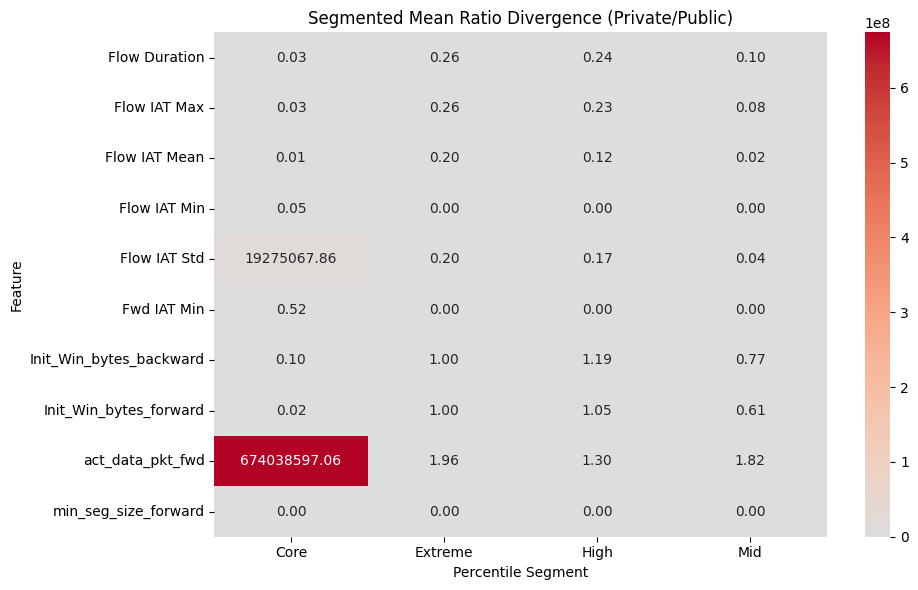

In [ ]:
# ===============================
# 6. Segment Ratio Heatmap
# ===============================

top_feats = df_seg.head(10)
heatmap_data = top_feats.melt(
    id_vars=["Feature"],
    value_vars=["Core", "Mid", "High", "Extreme"],
    var_name="Segment",
    value_name="Mean_Ratio"
)

plt.figure(figsize=(10, 6))
pivot = heatmap_data.pivot(index="Feature", columns="Segment", values="Mean_Ratio")
sns.heatmap(pivot, annot=True, cmap="coolwarm", center=1.0, fmt=".2f")
plt.title("Segmented Mean Ratio Divergence (Private/Public)")
plt.xlabel("Percentile Segment")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**7. PCA Projection of Both Distributions**

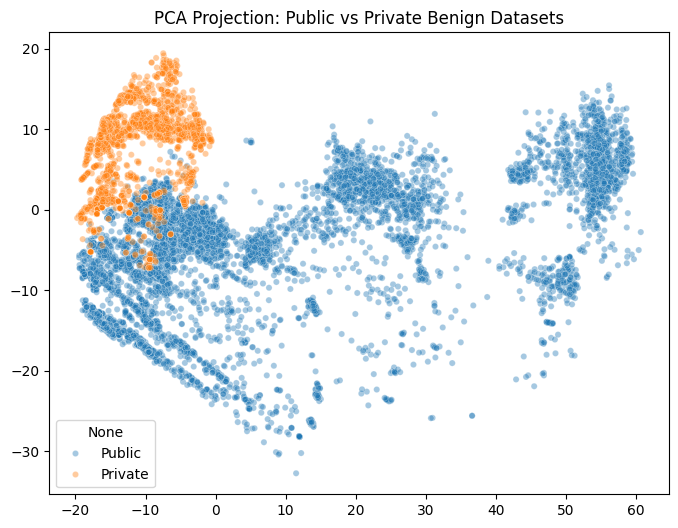

In [ ]:
# ===============================
# 7. PCA Projection of Both Distributions
# ===============================

pca = PCA(n_components=2)
combined = pd.concat([
    benign_public_log.sample(min(10000, len(benign_public_log)), random_state=42),
    benign_private_log.sample(min(5000, len(benign_private_log)), random_state=42)
], keys=["Public", "Private"])

pca_data = pca.fit_transform(combined)
labels = combined.index.get_level_values(0)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=labels, s=20, alpha=0.4)
plt.title("PCA Projection: Public vs Private Benign Datasets")
plt.show()


**8. Summary Report**

In [ ]:
# ===============================
# 8. Summary Report
# ===============================

mean_ks = drift_df['KS_Statistic'].mean()
strong_shift = (drift_df['KS_Statistic'] > 0.5).sum()
mild_shift = (drift_df['KS_Statistic'] > 0.2).sum()

print("=== Divergence Summary ===")
print(f"Mean KS-Statistic: {mean_ks:.3f}")
print(f"Strongly divergent features (KS > 0.5): {strong_shift}")
print(f"Mildly divergent features (KS > 0.2): {mild_shift}")
print(f"Significant differences (p < 0.05): {(drift_df['Earth_Mover_Distance'] > 0.1).sum()} / {len(drift_df)}")


=== Divergence Summary ===
Mean KS-Statistic: 0.383
Strongly divergent features (KS > 0.5): 12
Mildly divergent features (KS > 0.2): 50
Significant differences (p < 0.05): 54 / 55
